In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Stage/CSV-03-11/03-11/data_combined.csv',parse_dates=['Timestamp'])

In [ ]:
# Renommer la colonne pour supprimer les espaces autour de 'Timestamp'
#data.rename(columns=lambda x: x.strip(), inplace=True)

# Convertir la colonne Timestamp en datetime
#data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Filtrer les lignes avec des valeurs NaT résultant de la conversion incorrecte
#data = data.dropna(subset=['Timestamp'])

# Ajouter une colonne 'hour_minute_second' en extrayant l'heure, la minute et la seconde (sans la date)
data['hour_minute_second'] = data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Compter le nombre d'attaques par hour_minute_second
hour_minute_second_attacks = data.groupby('hour_minute_second').size().reset_index(name='y')

# Renommer la colonne 'hour_minute_second' en 'ds' pour Prophet
hour_minute_second_attacks.rename(columns={'hour_minute_second': 'ds'}, inplace=True)

# Afficher les premières lignes pour vérifier
print(hour_minute_second_attacks.head(len(hour_minute_second_attacks)))

# Mise à jour du dataframe principal
data = hour_minute_second_attacks

                        ds  y
0      2018-11-03 09:18:16  1
1      2018-11-03 09:18:18  8
2      2018-11-03 09:18:19  1
3      2018-11-03 09:18:20  3
4      2018-11-03 09:18:26  6
...                    ... ..
12219  2018-11-03 17:36:22  2
12220  2018-11-03 17:36:28  1
12221  2018-11-03 17:36:29  1
12222  2018-11-03 17:36:33  1
12223  2018-11-03 17:36:41  1

[12224 rows x 2 columns]


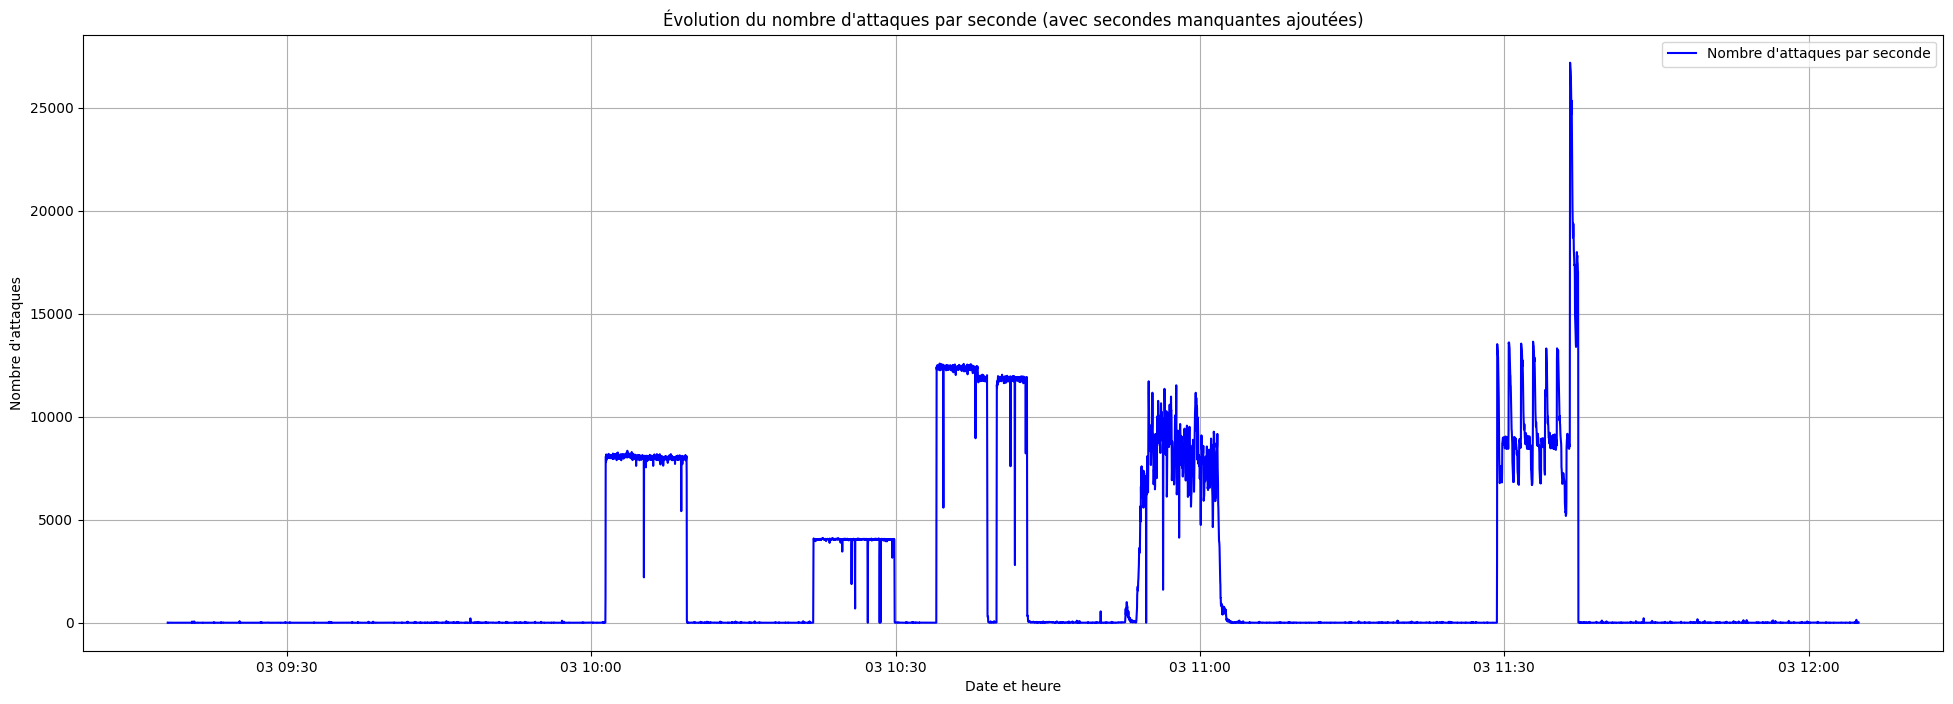

In [ ]:
# Convertir la colonne de dates en datetime si nécessaire
data['ds'] = pd.to_datetime(data['ds'])

# Déterminer la première et la dernière timestamp dans vos données existantes
start_time = data['ds'].min()
end_time = data['ds'].max()

# Générer une séquence de toutes les secondes entre le début et la fin
all_seconds = pd.date_range(start=start_time, end=end_time, freq='S')

# Créer un DataFrame avec toutes les secondes et fusionner avec vos données existantes
all_data = pd.DataFrame({'ds': all_seconds})

# Convertir la colonne de dates en datetime
all_data['ds'] = pd.to_datetime(all_data['ds'])

# Fusionner les données
merged_data = pd.merge(all_data, data, on='ds', how='left')

# Remplacer les NaN par 0 si vous voulez marquer les secondes sans attaque comme 0
merged_data['y'] = merged_data['y'].fillna(0)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 8))
plt.plot(merged_data['ds'][0:10000], merged_data['y'][0:10000], linestyle='-', color='b', label='Nombre d\'attaques par seconde')
plt.title('Évolution du nombre d\'attaques par seconde (avec secondes manquantes ajoutées)')
plt.xlabel('Date et heure')
plt.ylabel('Nombre d\'attaques')
plt.grid(True)
plt.legend()
plt.show()

# KNN

Mean Squared Error: 0.0019023538120308057
R²: 0.989825650702092
RMSE: 402.1146499404452


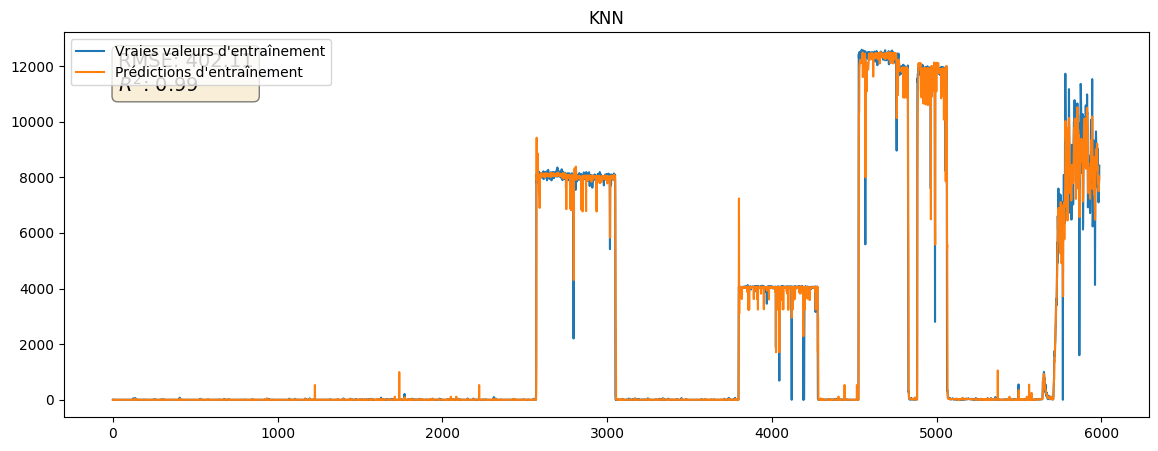

R²: 0.9042995021431517
RMSE: 1185.8312956164239


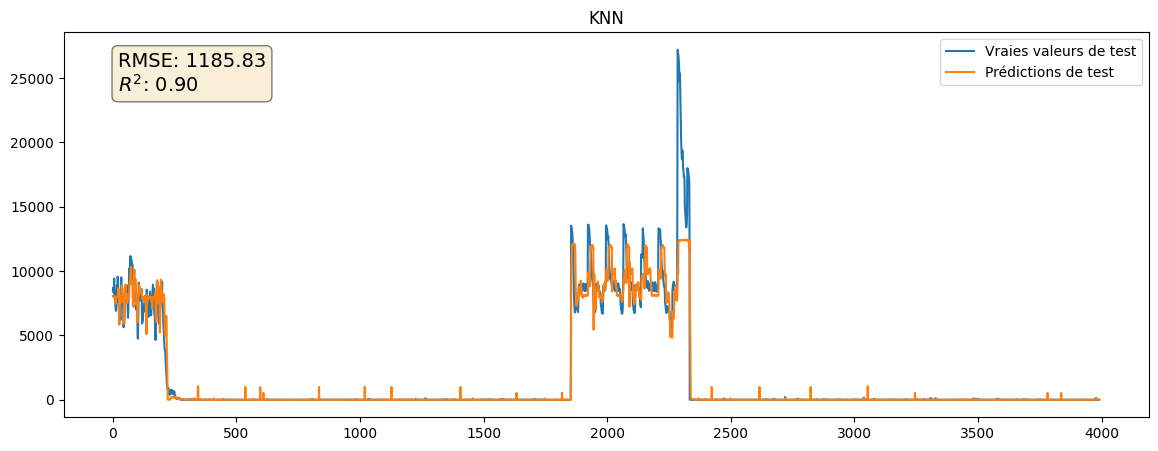

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

df = data[:10000].copy()
df = merged_data[0:10000].copy()
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(df['y'].values, seq_length)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Définir le modèle KNN Regressor
model = KNeighborsRegressor(n_neighbors=5)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Calculer l'erreur quadratique moyenne pour les prédictions de test
mse = mean_squared_error(y_test, test_predictions)
print("Mean Squared Error:", mse)

# Inverser la normalisation
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_train_true, train_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_train_true, train_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")






# Visualiser les résultats
plt.figure(figsize=(14, 5))

#plt.subplot(1, 2, 1)
plt.plot(y_train_true, label='Vraies valeurs d\'entraînement')
plt.plot(train_predictions, label='Prédictions d\'entraînement')
plt.title('KNN')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()
# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()

from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_test_true, test_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_test_true, test_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

plt.figure(figsize=(14, 5))
#plt.subplot(1, 2, 2)
plt.plot(y_test_true, label='Vraies valeurs de test')
plt.plot(test_predictions, label='Prédictions de test')
plt.title('KNN')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()
# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()


# SVM

R²: 0.6635397433411865
RMSE: 2312.4026582277606


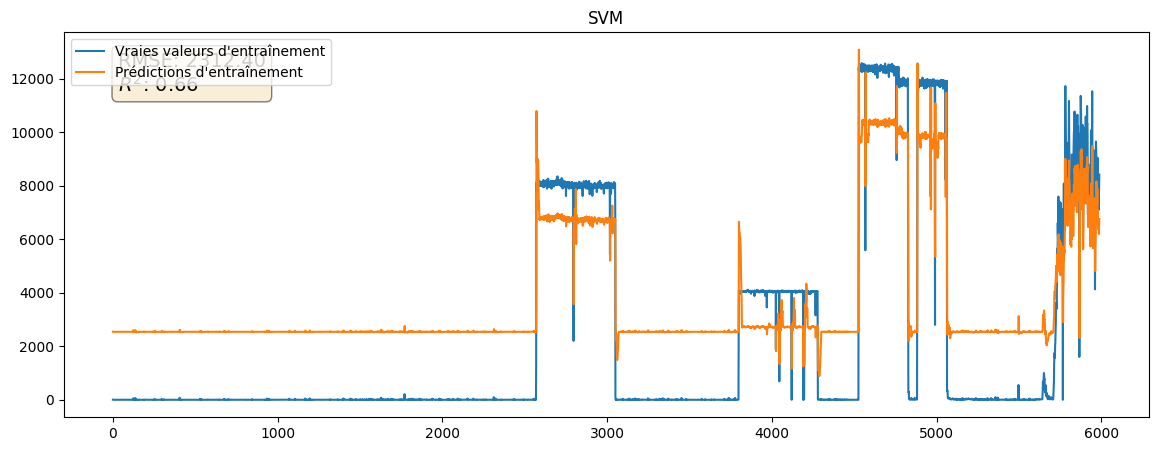

R²: 0.48337441373463075
RMSE: 2755.2040284812338


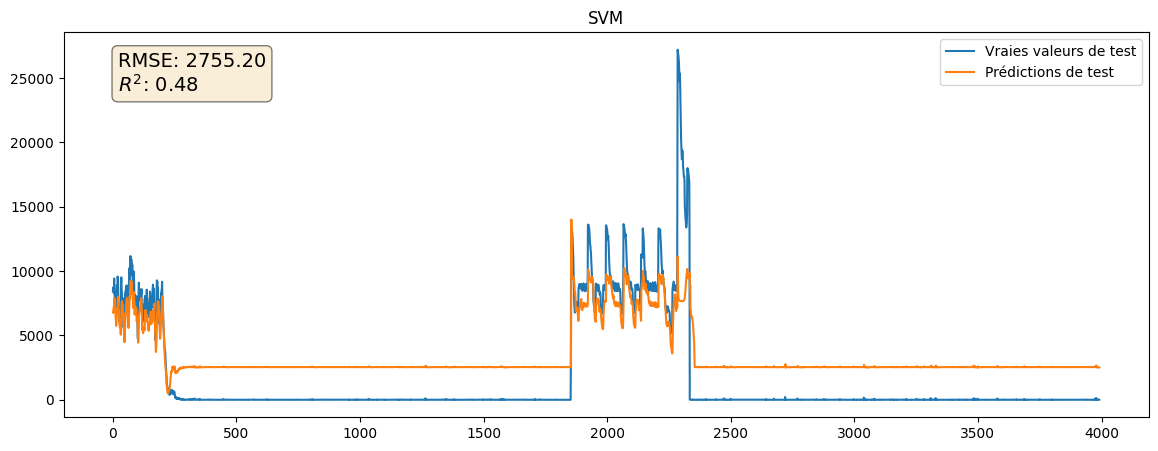

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

df = merged_data[0:10000].copy()
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(df['y'].values, seq_length)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Définir le modèle SVM
model = SVR(kernel='rbf')

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverser la normalisation
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))


from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_train_true, train_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_train_true, train_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")






# Visualiser les résultats
plt.figure(figsize=(14, 5))

#plt.subplot(1, 2, 1)
plt.plot(y_train_true, label='Vraies valeurs d\'entraînement')
plt.plot(train_predictions, label='Prédictions d\'entraînement')
plt.title('SVM')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()
# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()

from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_test_true, test_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_test_true, test_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

plt.figure(figsize=(14, 5))
#plt.subplot(1, 2, 2)
plt.plot(y_test_true, label='Vraies valeurs de test')
plt.plot(test_predictions, label='Prédictions de test')
plt.title('SVM')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()
# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()

# Random Forest

R²: 0.9980905530487428
RMSE: 174.20089124325835


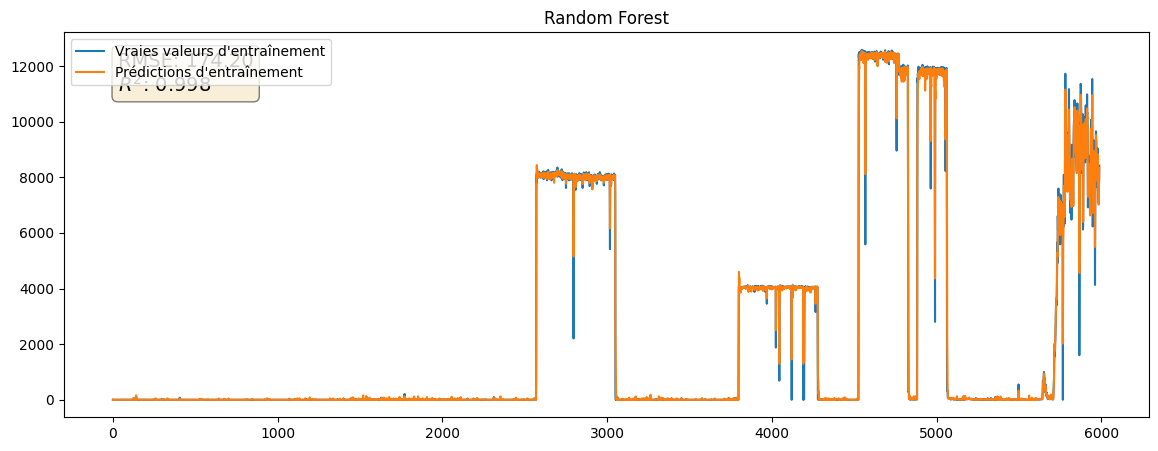

R²: 0.9115577664062207
RMSE: 1139.9758741349804


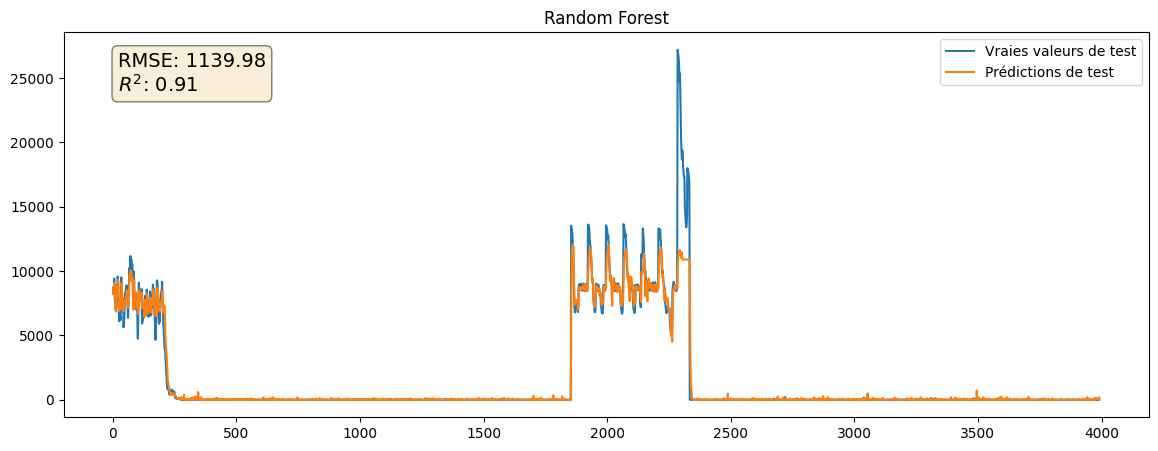

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Extrait de vos données pour les 10 000 premières lignes
df = merged_data[:10000].copy()
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Fonction pour créer des séquences temporelles
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(df['y'].values, seq_length)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Définir le modèle Random Forest avec max_features corrigé
model = RandomForestRegressor(
    n_estimators=100,         # Nombre d'arbres dans la forêt
    random_state=10,         # Graîne pour la reproductibilité
    max_depth=None,           # Profondeur maximale des arbres (None signifie pas de limite)
    min_samples_split=2,      # Nombre minimum d'échantillons pour diviser un nœud
    min_samples_leaf=1,       # Nombre minimum d'échantillons pour un nœud terminal
    max_features='sqrt',      # Nombre de caractéristiques à considérer pour la meilleure division (corrigé de 'auto' à 'sqrt')
    bootstrap=True,           # Si vrai, utilise le bootstrap pour les échantillons
    oob_score=False,          # Si vrai, utilise les échantillons hors sac pour évaluer la précision du modèle
    n_jobs=-1,                # Nombre de jobs à utiliser pour l'entraînement (-1 signifie utiliser tous les processeurs disponibles)
    verbose=0,                # Contrôle le niveau de verbosité (0 signifie silencieux)
    warm_start=False,         # Si vrai, réutilise la solution de l'appel précédent pour ajouter des arbres à l'ensemble
    ccp_alpha=0.0,            # Paramètre pour la taille minimale des coûts-complexité de l'élagage
    max_samples=None          # Si bootstrap est vrai, le nombre d'échantillons à tirer pour s’entraîner chaque arbre (None signifie utiliser la taille de l'ensemble de données)
)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverser la normalisation
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))


from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_train_true, train_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_train_true, train_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")






# Visualiser les résultats
plt.figure(figsize=(14, 5))

#plt.subplot(1, 2, 1)
plt.plot(y_train_true, label='Vraies valeurs d\'entraînement')
plt.plot(train_predictions, label='Prédictions d\'entraînement')
plt.title('Random Forest')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()
# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()

from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_test_true, test_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_test_true, test_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

plt.figure(figsize=(14, 5))
#plt.subplot(1, 2, 2)
plt.plot(y_test_true, label='Vraies valeurs de test')
plt.plot(test_predictions, label='Prédictions de test')
plt.title('Random Forest')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()
# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()

In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

# Charger les données (assurez-vous que vos données sont sous forme de DataFrame avec 'ds' et 'y')
df = merged_data[:10000].copy()  # Extrait de vos données pour les 10 000 premières lignes
df['ds'] = pd.to_datetime(df['ds'])  # Prophet nécessite que la colonne 'ds' soit de type datetime

# Normaliser les données de la série 'y' entre 0 et 1
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Diviser les données en ensembles d'entraînement et de test
train_size = int(0.6 * len(df))  # 60% pour l'entraînement
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# Liste pour stocker les prévisions
predictions = []

# Boucle pour faire une prévision à chaque itération
for i in range(len(test_df)):
    # Initialiser et entraîner le modèle Prophet sur les données d'entraînement disponibles
    model = Prophet()
    model.fit(train_df)

    # Faire une prévision pour un seul point
    future = model.make_future_dataframe(periods=1, freq='D')  # Prédire seulement le point suivant
    forecast = model.predict(future)

    # Extraire la prédiction et l'ajouter à la liste des prédictions
    next_pred = forecast['yhat'].iloc[-1]
    predictions.append(next_pred)

    # Ajouter la nouvelle prédiction à l'ensemble d'entraînement
    new_row = pd.DataFrame({'ds': [test_df['ds'].iloc[i]], 'y': [next_pred]})
    train_df = pd.concat([train_df, new_row], ignore_index=True)

# Inverser la normalisation des prédictions et des vraies valeurs
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_test_true = scaler.inverse_transform(test_df['y'].values.reshape(-1, 1))

# Calcul du R² et de la RMSE
r2 = r2_score(y_test_true, predictions)
rmse = np.sqrt(mean_squared_error(y_test_true, predictions))

print(f"R²: {r2}")
print(f"RMSE: {rmse}")

# Visualisation des résultats
plt.figure(figsize=(14, 5))
plt.plot(test_df['ds'], y_test_true, label='Valeurs réelles')
plt.plot(test_df['ds'], predictions, label='Prédictions de Prophet (un seul point à chaque itération)')
plt.title('Prévisions incrémentales avec Prophet')
plt.legend()
plt.show()

# Ajouter des annotations RMSE et R² dans la figure
textstr = f'RMSE: {rmse:.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwbd4sduh/lamhbg2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwbd4sduh/5u7bc3e8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43772', 'data', 'file=/tmp/tmpwbd4sduh/lamhbg2e.json', 'init=/tmp/tmpwbd4sduh/5u7bc3e8.json', 'output', 'file=/tmp/tmpwbd4sduh/prophet_modelnauto74_/prophet_model-20240912202921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:22 - cmdstanpy - INFO - Chain

ValueError: Found infinity in column y.